In [1]:
import numpy as np
import matplotlib.pyplot as plt

adc_raw shape:(2064384,)
63 received
tx1:(63, 16, 4, 256), tx2:(63, 16, 4, 256), virtual:(63, 16, 8, 256)
range fft:(63, 16, 8, 256)
doppler fft:(63, 16, 8, 256)
azimuth fft:(63, 16, 8, 256)
peak samples:[233 243 250 242]


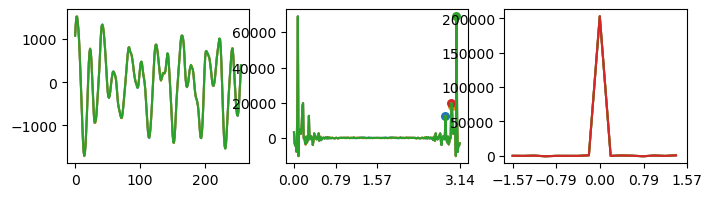

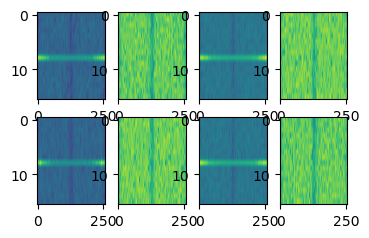

In [137]:
path = '../rawData/data1/data_Raw_0.bin'
num_rx=4
num_samples=256
num_chirps=32
num_frames=64

rad_range = np.arange(start=0, stop=np.pi, step=np.pi/(num_samples))
rad_doppler = np.arange(start=-np.pi/2, stop=np.pi/2, step=np.pi/(num_chirps//2))

adc_raw = np.fromfile(path, dtype=np.int16)
print(f'adc_raw shape:{adc_raw.shape}')

nframes = adc_raw.shape[0] // (num_samples*num_chirps*num_rx)
assert adc_raw.shape[0] == num_samples*num_chirps*num_rx*num_frames or 0 < nframes <num_frames
print(f'{nframes} received')
adc_raw = adc_raw[ :num_samples*num_chirps*num_rx*nframes]

adc_frames = adc_raw.reshape(nframes, num_chirps, num_rx, num_samples)
adc_tx1 = adc_frames[:, ::2, :, :]
adc_tx2 = adc_frames[:, 1::2, :, :]
adc_frames = np.concatenate([adc_tx1, adc_tx2], axis=-2)
print(f'tx1:{adc_tx1.shape}, tx2:{adc_tx2.shape}, virtual:{adc_frames.shape}')

save = False
chirps=[4, 8, 15]
for frame in [20]:
    range_fft = np.fft.fft(adc_frames, axis=-1)
    doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, axis=1), axes=1)
    azimuth_fft = np.abs(np.fft.fftshift(np.fft.fft(doppler_fft, axis=2), axes=2))
    print(f'range fft:{range_fft.shape}')
    print(f'doppler fft:{doppler_fft.shape}')
    print(f'azimuth fft:{azimuth_fft.shape}')

    fig1, ax1 = plt.subplots(1,3, figsize=(8, 2))
    for i, chirp_i in enumerate(chirps):
        ax1[0].plot(adc_frames[frame, chirp_i, 0])
        ax1[1].plot(rad_range, range_fft[frame, chirp_i, 0])
        xticks1 = [0, np.pi/4, np.pi/2, np.pi]
        xticks1 = [np.round(x, 2) for x in xticks1]
        ax1[1].set_xticks(xticks1)
    
    peak_smpls = np.argpartition(range_fft[frame, chirps[0], 0, num_samples//2:], -4)[-4:]+num_samples//2
    print(f'peak samples:{peak_smpls}')
    for id in peak_smpls:
        ax1[1].scatter(rad_range[id], range_fft[frame, 4, 0, id], s=30)

    for i, peak_smpl in enumerate(peak_smpls):
        ax1[2].plot(rad_doppler, doppler_fft[frame, :, 0, peak_smpls[0]])
        xticks2 = [-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2]
        xticks2 = [np.round(x, 2) for x in xticks2]
        ax1[2].set_xticks(xticks2)

    fig2, ax2 = plt.subplots(2, 4, figsize=(4, 2.5))
    for i in range(8):
        ax2[i//4, i%4].imshow(20*np.log10(azimuth_fft[frame, :, i, :] + 1e-6), aspect='auto')


range resolution:0.08m
power_map shape:(16, 128)
doppler peak: (array([8, 8, 8, 8, 8, 8, 8, 8], dtype=int64), array([23,  7,  5,  4, 14, 15,  6, 13], dtype=int64))
azimuth range:-1.00 ~ 1.00
elevation range:-0.62 ~ 0.62
azimuth angle range:-90.00 ~ 90.00
elevation angle range:-38.68 ~ 38.68
azim_bin:8, elev_bin:16, theta:-48.25,            phi:1.16, r:1.82, range_bin:23

azim_bin:60, elev_bin:16, theta:64.79,            phi:1.16, r:0.55, range_bin:7

azim_bin:52, elev_bin:16, theta:40.60,            phi:1.16, r:0.40, range_bin:5

azim_bin:41, elev_bin:16, theta:17.55,            phi:1.16, r:0.32, range_bin:4

azim_bin:30, elev_bin:16, theta:-2.73,            phi:1.16, r:1.11, range_bin:14

azim_bin:32, elev_bin:16, theta:0.91,            phi:1.16, r:1.19, range_bin:15

azim_bin:43, elev_bin:16, theta:21.41,            phi:1.16, r:0.48, range_bin:6

azim_bin:32, elev_bin:16, theta:0.91,            phi:1.16, r:1.03, range_bin:13



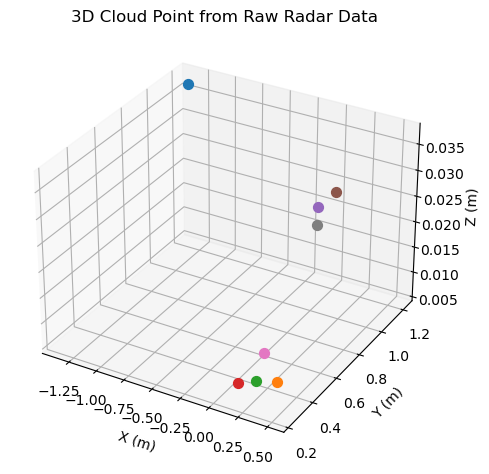

In [140]:
# Correcting complex conversion and reshaping

path = 'C:\\ti\\mmwave_studio_03_01_04_04\\mmWaveStudio\\PostProc\\adc_Data_Raw_0keep.bin'
NUM_RX=4
NUM_SAMPLES=256
NUM_CHIRPS=32
NUM_FRAMES_=64

RANGE_FFT_SIZE = NUM_SAMPLES
DOPPLER_FFT_SIZE = NUM_CHIRPS
ELEVATION_DIM=2
AZIMUTH_DIM=4
ELEVATION_FFT_SIZE=32
AZIMUTH_FFT_SIZE=64
range_res = 3e8/(2*1.893e9)
print(f'range resolution:{range_res:.2f}m')


# Peak detection over doppler/range
doppler_abs = np.abs(doppler_fft[frame])  # shape: (doppler, virtual_ant, range)
power_map = np.mean(doppler_abs, axis=1)[:, :NUM_SAMPLES//2]  # sum over virtual antennas
print(f'power_map shape:{power_map.shape}')

npoints = 8
indices = np.argpartition(power_map.flatten(), -npoints)[-npoints: ]
peak_idx = np.unravel_index(indices, power_map.shape)
doppler_bins, range_bins = peak_idx
print(f'doppler peak: {peak_idx}')

azimuth_axis = (1/0.5)*np.linspace(-AZIMUTH_FFT_SIZE/2, AZIMUTH_FFT_SIZE/2, AZIMUTH_FFT_SIZE)/AZIMUTH_FFT_SIZE
elevation_axis = (1/0.8)*np.linspace(-ELEVATION_FFT_SIZE/2, ELEVATION_FFT_SIZE/2, ELEVATION_FFT_SIZE)/ELEVATION_FFT_SIZE
print(f'azimuth range:{azimuth_axis.min():.2f} ~ {azimuth_axis.max():.2f}')
print(f'elevation range:{elevation_axis.min():.2f} ~ {elevation_axis.max():.2f}')
azimuth_axis = np.arcsin(azimuth_axis)
elevation_axis = np.arcsin(elevation_axis)
print(f'azimuth angle range:{(180/np.pi)*azimuth_axis.min():.2f} ~ {(180/np.pi)*azimuth_axis.max():.2f}')
print(f'elevation angle range:{(180/np.pi)*elevation_axis.min():.2f} ~ {(180/np.pi)*elevation_axis.max():.2f}')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for doppler_bin, range_bin in zip(doppler_bins, range_bins):
    # AoA estimation
    snapshot = doppler_fft[0, doppler_bin, :, range_bin]  # shape: (8,)
    antenna_2d = snapshot.reshape(ELEVATION_DIM, AZIMUTH_DIM)

    angle_fft2d = np.fft.fftshift(np.fft.fft2(antenna_2d, s=(ELEVATION_FFT_SIZE, AZIMUTH_FFT_SIZE)))
    angle_power = np.abs(angle_fft2d) ** 2
    angle_power /= np.max(angle_power)

    # Estimate azimuth and elevation angles
    elev_bin, azim_bin = np.unravel_index(np.argmax(angle_power), angle_power.shape)

    # azimuth_axis = np.arcsin(np.linspace(-1, 1, AZIMUTH_FFT_SIZE))
    # elevation_axis = np.arcsin(np.linspace(-1, 1, ELEVATION_FFT_SIZE))
    theta = azimuth_axis[azim_bin]
    phi = elevation_axis[elev_bin]

    # Range to Cartesian conversion
    r = range_bin * range_res
    x = r * np.cos(phi) * np.sin(theta)
    y = r * np.cos(phi) * np.cos(theta)
    z = r * np.sin(phi)
    print(f'azim_bin:{azim_bin}, elev_bin:{elev_bin}, theta:{(180/np.pi)*theta:.2f}, \
           phi:{(180/np.pi)*phi:.2f}, r:{r:.2f}, range_bin:{range_bin}\n')
    ax.scatter(x, y, z, s=50)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Cloud Point from Raw Radar Data')
plt.tight_layout()
plt.show()

In [110]:
a = np.random.random(size=(4,5))
print('a:', a)
b = np.fft.fft2(a)
c = np.fft.fft(a, axis=-1)
c = np.fft.fft(c, axis=0)
print('\nb:', b)
print('\nc:', c)
print(np.mean(np.abs(b-c)))
assert (b==c).all()

a: [[0.22475519 0.99190913 0.1317294  0.81905753 0.11589863]
 [0.84937236 0.75472861 0.41575917 0.98957414 0.97195401]
 [0.8702214  0.78081987 0.0316892  0.73082016 0.40260657]
 [0.50075547 0.09037241 0.83659393 0.84140775 0.84121762]]

b: [[12.19124254+0.j          0.09402993+0.88290182j -0.07689016-2.03710626j
  -0.07689016+2.03710626j  0.09402993-0.88290182j]
 [-0.53280732-0.87104113j -0.99420553-1.29527815j -1.38091454+0.09751297j
   0.32869766+0.66025838j -0.64810132-0.33453656j]
 [-1.99222839+0.j          0.73981223-1.63869683j -0.38157615-2.07452415j
  -0.38157615+2.07452415j  0.73981223+1.63869683j]
 [-0.53280732+0.87104113j -0.64810132+0.33453656j  0.32869766-0.66025838j
  -1.38091454-0.09751297j -0.99420553+1.29527815j]]

c: [[12.19124254+0.j          0.09402993+0.88290182j -0.07689016-2.03710626j
  -0.07689016+2.03710626j  0.09402993-0.88290182j]
 [-0.53280732-0.87104113j -0.99420553-1.29527815j -1.38091454+0.09751297j
   0.32869766+0.66025838j -0.64810132-0.33453656j]
 [-1.